## Face Attribute model
### Data Preparation
https://towardsdatascience.com/real-time-multi-facial-attribute-detection-using-transfer-learning-and-haar-cascades-with-fastai-47ff59e36df0

Data from Kaggle: [CelebFaces](https://www.kaggle.com/jessicali9530/celeba-dataset)

### Remarks
Only photos and file structure is used for modeling, while dataframe (label_df) was ignored.


root  
 |  
 +-- face  
     |  
     +-- training  
     +-- validation  

In [1]:
import pandas as pd
import numpy as np
import imutils
import glob
import cv2
import shutil
from tqdm import tqdm_notebook
from tqdm import tqdm
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 500)
tqdm_notebook().pandas()

Data Files

* **list_eval_partition.csv**: Recommended partitioning of images into training, validation, testing sets. Images 1-162770 are training, 162771-182637 are validation, 182638-202599 are testing
* **list_bbox_celeba.csv**: Bounding box information for each image. "x_1" and "y_1" represent the upper left point coordinate of bounding box. "width" and "height" represent the width and height of bounding box
* **list_landmarks_align_celeba.csv**: Image landmarks and their respective coordinates. There are 5 landmarks: left eye, right eye, nose, left mouth, right mouth
* **list_attr_celeba.csv**: Attribute labels for each image. There are 40 attributes. "1" represents positive while "-1" represents negative

In [2]:
import os

In [3]:
print('Total photo: ',len(os.listdir('img_align_celeba/')))

Total photo:  202599


In [4]:
import matplotlib.pyplot as plt

In [5]:
img = plt.imread(os.path.join('img_align_celeba/', os.listdir('img_align_celeba/')[0]))

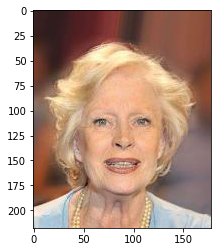

In [6]:
plt.imshow(img)

### csv info

In [7]:
import pandas as pd

In [8]:
df_partition = pd.read_csv('list_eval_partition.csv')
df_partition.head(3)

,image_id,partition
0,000001.jpg,0
1,000002.jpg,0
2,000003.jpg,0


In [9]:
df_box = pd.read_csv('list_bbox_celeba.csv')
df_box.head(3)

,image_id,x_1,y_1,width,height
0,000001.jpg,95,71,226,313
1,000002.jpg,72,94,221,306
2,000003.jpg,216,59,91,126


In [10]:
df_landmarks = pd.read_csv('list_landmarks_align_celeba.csv')
df_landmarks.head(3)

,image_id,lefteye_x,lefteye_y,righteye_x,righteye_y,nose_x,nose_y,leftmouth_x,leftmouth_y,rightmouth_x,rightmouth_y
0,000001.jpg,69,109,106,113,77,142,73,152,108,154
1,000002.jpg,69,110,107,112,81,135,70,151,108,153
2,000003.jpg,76,112,104,106,108,128,74,156,98,158


In [11]:
df_attr = pd.read_csv('list_attr_celeba.csv')
df_attr.head(3)

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,Blurry,Brown_Hair,Bushy_Eyebrows,Chubby,Double_Chin,Eyeglasses,Goatee,Gray_Hair,Heavy_Makeup,High_Cheekbones,Male,Mouth_Slightly_Open,Mustache,Narrow_Eyes,No_Beard,Oval_Face,Pale_Skin,Pointy_Nose,Receding_Hairline,Rosy_Cheeks,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,1,1,-1,1,-1,-1,1,-1,-1,1,-1,-1,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,1,-1,1,-1,-1,1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,1,1,-1,-1,1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,1


Find faces from photos

In [12]:
!cd /usr && find -name haarcascade*

./local/lib/python3.5/dist-packages/cv2/data/haarcascade_righteye_2splits.xml
./local/lib/python3.5/dist-packages/cv2/data/haarcascade_frontalface_alt.xml
./local/lib/python3.5/dist-packages/cv2/data/haarcascade_fullbody.xml
./local/lib/python3.5/dist-packages/cv2/data/haarcascade_frontalface_alt2.xml
./local/lib/python3.5/dist-packages/cv2/data/haarcascade_licence_plate_rus_16stages.xml
./local/lib/python3.5/dist-packages/cv2/data/haarcascade_frontalface_default.xml
./local/lib/python3.5/dist-packages/cv2/data/haarcascade_frontalcatface.xml
./local/lib/python3.5/dist-packages/cv2/data/haarcascade_eye.xml
./local/lib/python3.5/dist-packages/cv2/data/haarcascade_lowerbody.xml
./local/lib/python3.5/dist-packages/cv2/data/haarcascade_profileface.xml
./local/lib/python3.5/dist-packages/cv2/data/haarcascade_smile.xml
./local/lib/python3.5/dist-packages/cv2/data/haarcascade_frontalface_alt_tree.xml
./local/lib/python3.5/dist-packages/cv2/data/haarcascade_upperbody.xml
./local/lib/python3.5/d

In [13]:
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml') #specify link

In [14]:
def face_extractor(origin, destination, fc):
    ## Importing image using open cv
    img = cv2.imread(origin,1)

    ## Resizing to constant width
    img = imutils.resize(img, width=200)
    
    ## Finding actual size of image
    H,W,_ = img.shape
    
    ## Converting BGR to RGB
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    ## Detecting faces on the image
    face_coord = fc.detectMultiScale(gray,1.2,10,minSize=(50,50))
    
    ## If only one face is foung
    if len(face_coord) == 1:
        X, Y, w, h = face_coord[0]
    
    ## If no face found --> SKIP
    elif len(face_coord)==0:
        return None
    
    ## If multiple faces are found take the one with largest area
    else:
        max_val = 0
        max_idx = 0
        for idx in range(len(face_coord)):
            _, _, w_i, h_i = face_coord[idx]
            if w_i*h_i > max_val:
                max_idx = idx
                max_val = w_i*h_i
            else:
                pass
            
            X, Y, w, h = face_coord[max_idx]
    
    ## Crop and export the image
    img_cp = img[
            max(0,Y - int(0.35*h)): min(Y + int(1.35*h), H),
            max(0,X - int(w*0.35)): min(X + int(1.35*w), W)
        ].copy()
    
    cv2.imwrite(destination, img_cp)

In [15]:
## Defining destination path
path = 'face/'

## Finding all the images in the folder
item_list = glob.glob('img_align_celeba/*.jpg')
print(len(item_list))

202599


In [43]:
## Will run for about an hour and a half 
for org in tqdm(item_list):
    face_extractor(origin = org, destination = path+org.split('/')[-1], fc=face_cascade)

100%|██████████| 202599/202599 [31:45<00:00, 106.31it/s]


In [36]:
os.mkdir('face/training/')
os.mkdir('face/validation/')

In [37]:
## Findign all the images and separating in training and validation
item_list = glob.glob(path+'*.jpg')

for idx in tqdm(range(1,202600)):
    if idx <= 182637:
        destination = path+'training/'
    else:
        destination = path+'validation/'
    try:
        shutil.move(
            path+str(idx).zfill(6)+'.jpg', 
            destination+str(idx).zfill(6)+'.jpg'
        )
    except:
        pass

### Create Label

In [17]:
## Combining all label attributes
label_df = pd.read_csv('list_attr_celeba.csv')
column_list = pd.Series(list(label_df.columns)[1:])

def label_generator(row):
    return(' '.join(column_list[[True if i==1 else False for i in row[column_list]]]))

label_df['label'] = df_attr.progress_apply(lambda x: label_generator(x), axis=1)
label_df = label_df.loc[:,['image_id','label']]
label_df.to_csv('labels.csv')

In [18]:
label_df['label'] = df_attr.progress_apply(lambda x: label_generator(x), axis=1)
label_df = label_df.loc[:,['image_id','label']]
label_df.to_csv('labels.csv')

In [21]:
label_df.head()

,image_id,label
0,000001.jpg,Arched_Eyebrows Attractive Brown_Hair Heavy_Ma...
1,000002.jpg,Bags_Under_Eyes Big_Nose Brown_Hair High_Cheek...
2,000003.jpg,Big_Lips Blurry Male Narrow_Eyes No_Beard Poin...
3,000004.jpg,Attractive No_Beard Pointy_Nose Straight_Hair ...
4,000005.jpg,Arched_Eyebrows Attractive Big_Lips Heavy_Make...


In [64]:
## Attachhing label to correct file names
item_list = glob.glob('face/*/*.jpg')
item_df = pd.DataFrame({'image_name':pd.Series(item_list).apply(lambda x: x.split('/')[-2])})
item_df['image_id'] = pd.Series(item_list).apply(lambda x: x.split('/')[-1])

In [65]:
item_df.head()

,image_name,image_id
0,validation,193919.jpg
1,validation,184672.jpg
2,validation,198061.jpg
3,validation,190474.jpg
4,validation,183447.jpg


In [70]:
## Creating final label set
label_df = pd.read_csv('labels.csv', index_col=0)

In [71]:
label_df.head()

,image_id,label
0,000001.jpg,Arched_Eyebrows Attractive Brown_Hair Heavy_Ma...
1,000002.jpg,Bags_Under_Eyes Big_Nose Brown_Hair High_Cheek...
2,000003.jpg,Big_Lips Blurry Male Narrow_Eyes No_Beard Poin...
3,000004.jpg,Attractive No_Beard Pointy_Nose Straight_Hair ...
4,000005.jpg,Arched_Eyebrows Attractive Big_Lips Heavy_Make...


In [72]:
label_df = label_df.merge(item_df, on='image_id', how='inner')

In [73]:
label_df.head()

,image_id,label,image_name
0,000001.jpg,Arched_Eyebrows Attractive Brown_Hair Heavy_Ma...,training
1,000002.jpg,Bags_Under_Eyes Big_Nose Brown_Hair High_Cheek...,training
2,000005.jpg,Arched_Eyebrows Attractive Big_Lips Heavy_Make...,training
3,000006.jpg,Arched_Eyebrows Attractive Big_Lips Brown_Hair...,training
4,000007.jpg,5_o_Clock_Shadow Attractive Bags_Under_Eyes Bi...,training


In [ ]:
label_df.rename(columns={'label':'tags'}, inplace=True)

In [ ]:
label_df.loc[:,['image_name','tags']].to_csv('face/labels.csv', index=False)

In [61]:
label_df

,Unnamed: 0,image_id,tags,image_name


In [ ]:
label_df.loc[:,['image_name','tags']].to_csv('face/labels.csv', index=False)